In [61]:
import numpy as np
np.random.seed(1) # for reproducibility

import keras.backend as K
import tensorflow as tf
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import pickle
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import Huber
# from tensorflow.keras import optimizers
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

In [10]:
hsbc = yf.download('AAPL', start='1980-01-01', end='2024-05-31')
# hsbc = hsbc.drop(['Adj Close'], axis=1)
#remove row with volume = 0
# hsbc = hsbc.drop(hsbc[hsbc.Volume==0].index)
print(hsbc.shape)

[*********************100%***********************]  1 of 1 completed

(10957, 6)


In [11]:
hsbc.head(2)

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
1980-12-12 00:00:00+00:00,0.098834,0.128348,0.128906,0.128348,0.128348,469033600
1980-12-15 00:00:00+00:00,0.093678,0.121652,0.122210,0.121652,0.122210,175884800


In [12]:
def create_data(dataset,window_size = 10):
    # df = dataset.to_numpy()
    df = dataset.copy()
    X = []
    y = []
    for i in range(len(df)-window_size):
        row = [a for a in df[i:i+window_size]]
        X.append(row)
        label = df[i+window_size]
        y.append(label)
        
    return np.array(X),np.array(y)

In [13]:
hsbc.describe()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
count,10957.000000,10957.000000,10957.000000,10957.000000,10957.000000,1.095700e+04
mean,20.747124,21.590338,21.808646,21.354338,21.577175,3.190060e+08
std,44.022975,44.574159,45.014408,44.095707,44.540256,3.357277e+08
min,0.037815,0.049107,0.049665,0.049107,0.049665,0.000000e+00
25%,0.241080,0.296875,0.303571,0.290179,0.296875,1.139152e+08
50%,0.426580,0.524554,0.533482,0.514464,0.522321,2.066456e+08
75%,17.024294,19.714287,19.903214,19.491072,19.785713,3.992352e+08
max,197.144196,198.110001,199.619995,197.000000,198.020004,7.421641e+09


In [14]:
data = hsbc[[('Adj Close','AAPL')]]

In [15]:
data

Price,Adj Close
Ticker,AAPL
Date,
1980-12-12 00:00:00+00:00,0.098834
1980-12-15 00:00:00+00:00,0.093678
1980-12-16 00:00:00+00:00,0.086802
1980-12-17 00:00:00+00:00,0.088951
1980-12-18 00:00:00+00:00,0.091530
...,...
2024-05-23 00:00:00+00:00,186.458801
2024-05-24 00:00:00+00:00,189.551804


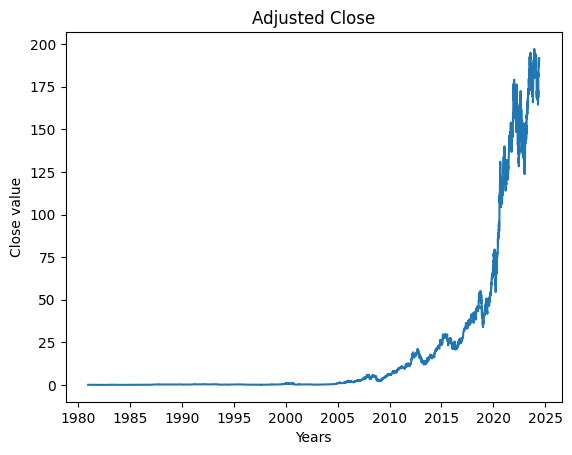

In [16]:
plt.title('Adjusted Close')
plt.xlabel('Years')
plt.ylabel('Close value')
plt.plot(data)

In [17]:
scaler = MinMaxScaler()
hsbc_scaled = scaler.fit_transform(data)

In [18]:
hsbc_scaled

array([[3.09576855e-04],
       [2.83417129e-04],
       [2.48533589e-04],
       ...,
       [9.61531446e-01],
       [9.63049999e-01],
       [9.68111944e-01]])

In [19]:
WINDOW_SIZE = 10

X,y = create_data(hsbc_scaled,WINDOW_SIZE)

In [20]:
X.shape

(10947, 10, 1)

In [21]:
y.shape

(10947, 1)

In [22]:
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [23]:
X_train.shape

(8757, 10, 1)

In [24]:
X_test.shape

(2190, 10, 1)

In [75]:
model_mse = Sequential()
model_mse.add(InputLayer(shape = (10,1)))
model_mse.add(LSTM(64))
model_mse.add(Dense(8,'relu'))
model_mse.add(Dense(1,'linear'))

# model_mse.summary()
model_mse.compile(loss='mse',optimizer=Adam(learning_rate=0.001),metrics = [RootMeanSquaredError()])
# history_mse = model_mse.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=10,callbacks=[cp])
history_mse = model_mse.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=50)

Epoch 1/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0110 - root_mean_squared_error: 0.0914 - val_loss: 8.8911e-05 - val_root_mean_squared_error: 0.0094
Epoch 2/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.3405e-05 - root_mean_squared_error: 0.0086 - val_loss: 6.7094e-05 - val_root_mean_squared_error: 0.0082
Epoch 3/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.3353e-05 - root_mean_squared_error: 0.0091 - val_loss: 7.1095e-05 - val_root_mean_squared_error: 0.0084
Epoch 4/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.7957e-05 - root_mean_squared_error: 0.0094 - val_loss: 5.2026e-05 - val_root_mean_squared_error: 0.0072
Epoch 5/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.6873e-05 - root_mean_squared_error: 0.0088 - val_loss: 9.4726e-05 - val_root_mean_squared_error: 0.0097
Epoch 6/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.2000e-05 - root_mean_squared_error: 0.0085 - val_loss: 7.4223e-05 - val_root_mean_squared_error: 0.0086
Epoch 7/

In [76]:
model_mae = Sequential()
model_mae.add(InputLayer(shape = (10,1)))
model_mae.add(LSTM(64))
model_mae.add(Dense(8,'relu'))
model_mae.add(Dense(1,'linear'))

# model_mae.summary()
# cp = model_maeCheckpoint('output/best_model.weights.h5',save_weights_only=False)
# cp = model_maeCheckpoint('output/best_model.keras',save_weights_only=False)
model_mae.compile(loss='mae',optimizer=Adam(learning_rate=0.001),metrics = [RootMeanSquaredError()])
history_mae = model_mae.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=50)

Epoch 1/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0228 - root_mean_squared_error: 0.1411 - val_loss: 1.0627e-04 - val_root_mean_squared_error: 0.0103
Epoch 2/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2229e-04 - root_mean_squared_error: 0.0111 - val_loss: 1.1283e-04 - val_root_mean_squared_error: 0.0106
Epoch 3/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3832e-04 - root_mean_squared_error: 0.0117 - val_loss: 8.7465e-05 - val_root_mean_squared_error: 0.0094
Epoch 4/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.6316e-05 - root_mean_squared_error: 0.0098 - val_loss: 1.0522e-04 - val_root_mean_squared_error: 0.0103
Epoch 5/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1999e-04 - root_mean_squared_error: 0.0109 - val_loss: 1.2203e-04 - val_root_mean_squared_error: 0.0110
Epoch 6/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0760e-04 - root_mean_squared_error: 0.0103 - val_loss: 9.3124e-05 - val_root_mean_squared_error: 0.0097
Epoch 7/

In [ ]:
import tensorflow as tf
import keras.backend as K
def custom_loss(y_true, y_pred):
    y_true_next = y_true[1:]
    y_pred_next = y_pred[1:]
    
    y_true_tdy = y_true[:-1]
    y_pred_tdy = y_pred[:-1]
    
    y_true_diff = tf.subtract(y_true_next, y_true_tdy)
    y_pred_diff = tf.subtract(y_pred_next, y_pred_tdy)
    
    y_true_move = tf.cast(tf.greater_equal(y_true_diff, 0), tf.float32)
    y_pred_move = tf.cast(tf.greater_equal(y_pred_diff, 0), tf.float32)
    
    direction_mismatch = tf.not_equal(y_true_move, y_pred_move)
    
    penalty_factor = tf.reduce_mean(tf.abs(y_true_diff)) 
    penalty = tf.where(direction_mismatch, 
                       (tf.abs(y_true_diff - y_pred_diff) * penalty_factor), 
                       tf.zeros_like(y_true_diff))   
    # Mean squared error loss
    # mse_loss = K.mean(K.square(y_true - y_pred), axis=-1)
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
    
    custom_loss = mse_loss + penalty
    
    return custom_loss


In [ ]:
model_custom = Sequential()
model_custom.add(InputLayer(shape = (10,1)))
model_custom.add(LSTM(64))
model_custom.add(Dense(8,'relu'))
model_custom.add(Dense(1,'linear'))

model_custom.compile(loss=custom_loss,optimizer=Adam(learning_rate=0.001),metrics = [RootMeanSquaredError()])
# model_custom.compile(loss=custom_loss,optimizer=Adam(learning_rate=0.0001),metrics = ['accuracy'])

history_custom = model_custom.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=50)

Epoch 1/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0039 - root_mean_squared_error: 0.0521 - val_loss: 8.4409e-05 - val_root_mean_squared_error: 0.0075
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 9.4244e-05 - root_mean_squared_error: 0.0087 - val_loss: 4.4811e-05 - val_root_mean_squared_error: 0.0066
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 8.5922e-05 - root_mean_squared_error: 0.0085 - val_loss: 5.2126e-05 - val_root_mean_squared_error: 0.0065
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 9.8130e-05 - root_mean_squared_error: 0.0083 - val_loss: 4.9179e-05 - val_root_mean_squared_error: 0.0070
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 7.9893e-05 - root_mean_squared_error: 0.0081 - val_loss: 7.2015e-05 - val_root_mean_squared_error: 0.0066
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 7.3750e-05 - root_mean_squared_error: 0.0077 - val_loss: 4.5220e-05 - val_root_mean_squared_error: 0.0

In [79]:
model_huber = Sequential()
model_huber.add(InputLayer(shape = (10,1)))
model_huber.add(LSTM(64))
model_huber.add(Dense(8,'relu'))
model_huber.add(Dense(1,'linear'))

model_huber.compile(loss='Huber',optimizer=Adam(learning_rate=0.001),metrics = [RootMeanSquaredError()])
# model_huber.compile(loss=huber_loss,optimizer=Adam(learning_rate=0.0001),metrics = ['accuracy'])

history_huber = model_huber.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=50)

Epoch 1/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0037 - root_mean_squared_error: 0.0740 - val_loss: 3.4983e-05 - val_root_mean_squared_error: 0.0084
Epoch 2/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.4091e-05 - root_mean_squared_error: 0.0082 - val_loss: 3.1222e-05 - val_root_mean_squared_error: 0.0079
Epoch 3/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.6304e-05 - root_mean_squared_error: 0.0085 - val_loss: 2.9428e-05 - val_root_mean_squared_error: 0.0077
Epoch 4/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.5957e-05 - root_mean_squared_error: 0.0085 - val_loss: 2.8801e-05 - val_root_mean_squared_error: 0.0076
Epoch 5/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.5649e-05 - root_mean_squared_error: 0.0084 - val_loss: 3.0318e-05 - val_root_mean_squared_error: 0.0078
Epoch 6/50
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.6998e-05 - root_mean_squared_error: 0.0086 - val_loss: 3.8854e-05 - val_root_mean_squared_error: 0.0088
Epoch 7/

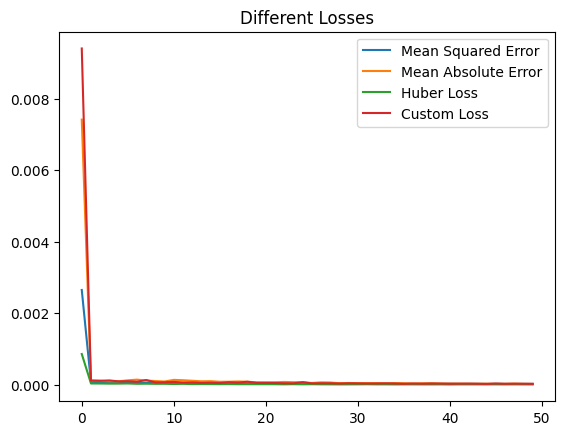

In [80]:
plt.plot(history_mse.history['loss'],label = 'Mean Squared Error')
plt.plot(history_mae.history['loss'],label = 'Mean Absolute Error')
plt.plot(history_huber.history['loss'],label = 'Huber Loss')
plt.plot(history_custom.history['loss'],label = 'Custom Loss')
plt.gca().set_xscale('linear')
plt.title('Different Losses')
plt.legend()
plt.show()

In [123]:
train_predictions_mse = model_mse.predict(X_train).flatten()
train_predictions_mae = model_mae.predict(X_train).flatten()
train_predictions_custom = model_custom.predict(X_train).flatten()
train_predictions_huber = model_huber.predict(X_train).flatten()

test_predictions_mse= model_mse.predict(X_test).flatten()
test_predictions_mae= model_mae.predict(X_test).flatten()
test_predictions_custom= model_custom.predict(X_test).flatten()
test_predictions_huber = model_huber.predict(X_test).flatten()

274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [124]:
huber_loss = tf.keras.losses.Huber(delta=1.0)  # delta is the threshold for transition between quadratic and linear loss

print("MAE model " ,mean_absolute_error(Y_train,train_predictions_mae))
print("MSE model " ,mean_absolute_error(Y_train,train_predictions_mse))
print("Huber model " ,mean_absolute_error(Y_train,train_predictions_huber))
print("Custom model " ,mean_absolute_error(Y_train,train_predictions_custom))
print()

print("MAE model " ,mean_squared_error(Y_train,train_predictions_mae))
print("MSE model " ,mean_squared_error(Y_train,train_predictions_mse))
print("Huber model " ,mean_squared_error(Y_train,train_predictions_huber))
print("Custom model " ,mean_squared_error(Y_train,train_predictions_custom))
print()

print("MAE model " ,huber_loss(Y_train,train_predictions_mae))
print("MSE model " ,huber_loss(Y_train,train_predictions_mse))
print("Huber model " ,huber_loss(Y_train,train_predictions_huber))
print("Custom model " ,huber_loss(Y_train,train_predictions_custom))

MAE model  0.0019057032466193824
MSE model  0.0021929353775929023
Huber model  0.0022499908431170726
Custom model  0.003114710249379808

MAE model  2.1389757630573622e-05
MSE model  2.3769038968091638e-05
Huber model  2.070536484889455e-05
Custom model  2.493398032740015e-05

MAE model  tf.Tensor(1.0694879e-05, shape=(), dtype=float32)
MSE model  tf.Tensor(1.1884519e-05, shape=(), dtype=float32)
Huber model  tf.Tensor(1.0352682e-05, shape=(), dtype=float32)
Custom model  tf.Tensor(1.24669905e-05, shape=(), dtype=float32)


In [126]:
print("MAE model " ,mean_absolute_error(Y_test,test_predictions_mae))
print("MSE model " ,mean_absolute_error(Y_test,test_predictions_mse))
print("Huber model " ,mean_absolute_error(Y_test,test_predictions_huber))
print("Custom model " ,mean_absolute_error(Y_test,test_predictions_custom))
print()

print("MAE model " ,mean_squared_error(Y_test,test_predictions_mae))
print("MSE model " ,mean_squared_error(Y_test,test_predictions_mse))
print("Huber model " ,mean_squared_error(Y_test,test_predictions_huber))
print("Custom model " ,mean_squared_error(Y_test,test_predictions_custom))
print()

huber_loss = tf.keras.losses.Huber(delta=1.0)  # delta is the threshold for transition between quadratic and linear loss
print("MAE model " ,huber_loss(Y_test,test_predictions_mae))
print("MSE model " ,huber_loss(Y_test,test_predictions_mse))
print("Huber model " ,huber_loss(Y_test,test_predictions_huber))
print("Custom model " ,huber_loss(Y_test,test_predictions_custom))

MAE model  0.0018565632118895039
MSE model  0.0021353111364372057
Huber model  0.002193924823317489
Custom model  0.0030497245867969164

MAE model  1.7572797952158525e-05
MSE model  1.9957318477223677e-05
Huber model  1.6703810418525913e-05
Custom model  2.115687351511079e-05

MAE model  tf.Tensor(8.7864e-06, shape=(), dtype=float32)
MSE model  tf.Tensor(9.978661e-06, shape=(), dtype=float32)
Huber model  tf.Tensor(8.351907e-06, shape=(), dtype=float32)
Custom model  tf.Tensor(1.0578438e-05, shape=(), dtype=float32)


In [127]:
print("MAE model " ,r2_score(Y_test,test_predictions_mae))
print("MSE model " ,r2_score(Y_test,test_predictions_mse))
print("Huber model " ,r2_score(Y_test,test_predictions_huber))
print("Custom model " ,r2_score(Y_test,test_predictions_custom))

MAE model  0.999653817837631
MSE model  0.9996068430488791
Huber model  0.9996709367952542
Custom model  0.9995832119482413


In [128]:
print("MAE model " ,r2_score(Y_train,train_predictions_mae))
print("MSE model " ,r2_score(Y_train,train_predictions_mse))
print("Huber model " ,r2_score(Y_train,train_predictions_huber))
print("Custom model " ,r2_score(Y_train,train_predictions_custom))

MAE model  0.9995696399617301
MSE model  0.999521769030925
Huber model  0.9995834098841763
Custom model  0.9994983305134517
